In [154]:
import numpy as np
import sklearn
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import math
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 30)

In [155]:
import warnings
warnings.filterwarnings("ignore")

In [156]:
!pip install prince
import prince

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [157]:
import sklearn
from sklearn.cluster import KMeans

In [158]:
from google.colab import files
uploaded1 = files.upload() 

Saving german_credit_data.csv to german_credit_data (1).csv


#Loading dataset

In [159]:
df = pd.read_csv('german_credit_data.csv')
numerical = ['Credit amount','Age','Duration']
categorical = ['Sex','Job','Housing','Saving accounts','Checking account','Purpose']
unused = ['Unnamed: 0']

In [160]:
df.drop(labels=unused, axis='columns', inplace=True)

In [161]:
df.Job = pd.DataFrame(df.Job).astype(object)

In [162]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


In [163]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   object
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(3), object(6)
memory usage: 70.4+ KB


In [164]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,1000.0,35.546,11.375469,19.0,27.0,33.0,42.00,75.0
Credit amount,1000.0,3271.258,2822.736876,250.0,1365.5,2319.5,3972.25,18424.0
Duration,1000.0,20.903,12.058814,4.0,12.0,18.0,24.00,72.0


In [165]:
df.describe(include='object').transpose()

,count,unique,top,freq
Sex,1000,2,male,690
Job,1000,4,2,630
Housing,1000,3,own,713
Saving accounts,817,4,little,603
Checking account,606,3,little,274
Purpose,1000,8,car,337


# EDA

##Missing values

In [166]:
df.isnull().sum(axis=0).reset_index()

,index,0
0,Age,0
1,Sex,0
2,Job,0
3,Housing,0
4,Saving accounts,183
5,Checking account,394
6,Credit amount,0
7,Duration,0
8,Purpose,0


In [167]:
df['Saving accounts'].fillna(df['Saving accounts'].mode().values[0], inplace=True)
df['Checking account'].fillna(df['Checking account'].mode().values[0], inplace=True)

In [168]:
df.isnull().sum(axis=0).sum()

0

## Explore variables

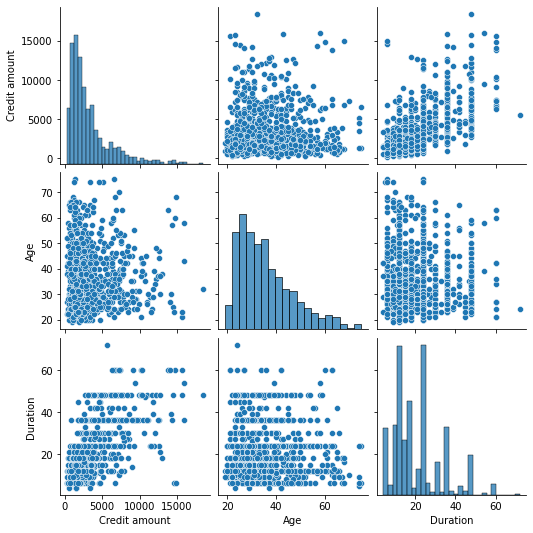

In [169]:
sn.pairplot(df[numerical])

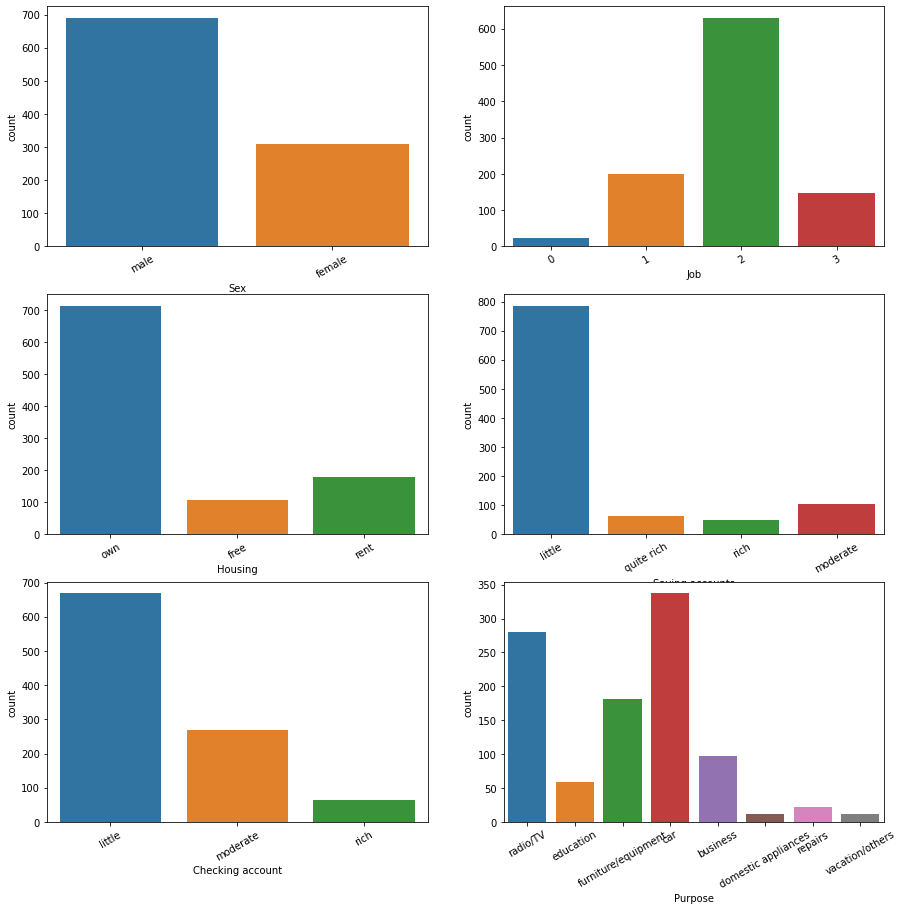

In [170]:
fig = plt.figure(figsize = (15,15))
axes = 320
for cat in categorical:
    axes += 1
    fig.add_subplot(axes)
    sn.countplot(data = df, x = cat)
    plt.xticks(rotation=30)
plt.show()

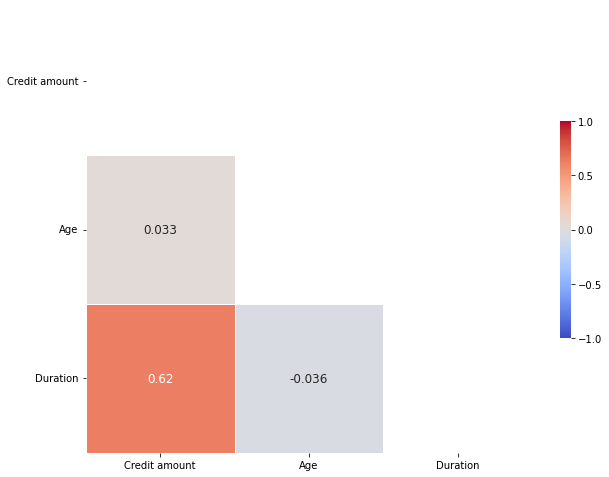

In [171]:
corr=df[numerical].corr(method='pearson')

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(10,10))

heatmap = sn.heatmap(corr,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 12})

ax.set_yticklabels(corr.columns, rotation = 0)
ax.set_xticklabels(corr.columns)

sn.set_style({'xtick.bottom': True}, {'ytick.left': True})

# KMeans Clustering

##Get dummies

In [172]:
df_dummy = df.copy()

In [173]:
#creating dummy variable
for cat in categorical:
  dummy = pd.get_dummies(df_dummy[cat], prefix=cat)
  df_dummy = pd.concat([df_dummy, dummy], axis=1)
  del df_dummy[cat]

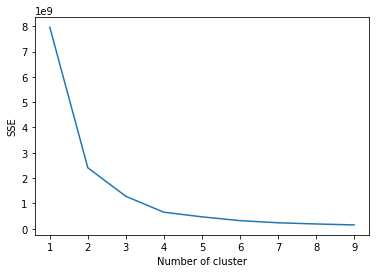

In [174]:
#elbow method
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=10000, init='k-means++', random_state=0).fit(df_dummy)
    #df_dummy["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

The elbow method suggests k = 3 as optimal number of cluster for Getdummies + KMeans

In [175]:
kmeans = KMeans(n_clusters=3,max_iter=10000, init='k-means++', random_state=0)
kmeans.fit(df_dummy)

KMeans(max_iter=10000, n_clusters=3, random_state=0)

In [176]:
clusters = kmeans.predict(df_dummy)

In [177]:
df_dummy_clust = df_dummy.copy()
df_dummy_clust['cluster'] = clusters

In [178]:
df_dummy_clust.cluster.value_counts()

1    728
2    216
0     56
Name: cluster, dtype: int64

<AxesSubplot:xlabel='cluster', ylabel='Credit amount'>

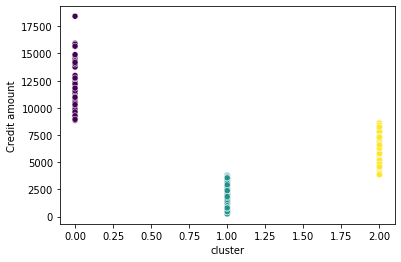

In [179]:
sn.scatterplot(x=df_dummy_clust['cluster'], y=df_dummy_clust['Credit amount'], c=df_dummy_clust['cluster'])

##PCA + MCA

In [180]:
df_pca = df[numerical].copy()

In [181]:
nb_component_pca = 2

pca = prince.PCA(
    n_components=nb_component_pca,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=0
)
pca = pca.fit(df_pca)

In [182]:
pca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,1.625,54.17%,54.17%
1,1.004,33.46%,87.63%


to get ~ 90% of variance explained we choose 2 components 

In [183]:
df_mca = df[categorical].copy()

In [184]:
nb_component_mca = 13

mca = prince.MCA(
    n_components=nb_component_mca,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=0
)
mca = mca.fit(df_mca)

In [185]:
mca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.244,8.12%,8.12%
1,0.217,7.24%,15.36%
2,0.209,6.98%,22.34%
3,0.192,6.39%,28.73%
4,0.182,6.06%,34.79%
5,0.179,5.97%,40.76%
6,0.175,5.85%,46.61%
7,0.171,5.70%,52.31%
8,0.170,5.68%,57.99%


to get ~ 90% of variance explained we choose 12 components 

In [186]:
df_pca = pca.row_coordinates(df_pca)
df_pca.columns = ['pca_{}'.format(_) for _ in range(nb_component_pca)]

In [187]:
df_mca = mca.row_coordinates(df_mca)
df_mca.columns = ['mca_{}'.format(_) for _ in range(nb_component_mca)]

In [188]:
df_pca_mca = pd.concat([df_pca,df_mca], axis=1)

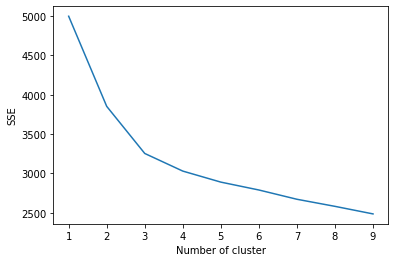

In [189]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k,
                    max_iter=10000,
                    init='k-means++',
                    random_state=0).fit(df_pca_mca)
    #df_pca_mca["cluster"] = kmeans.labels_
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

The elbow method suggests k = 3 as optimal number of cluster for PCA + MCA + KMeans

In [190]:
kmeans_pca_mca = KMeans(n_clusters=3,max_iter=10000, init='k-means++', random_state=0).fit(df_pca_mca)

In [191]:
clusters = kmeans_pca_mca.labels_

In [192]:
df_pca_mca_clust = df_pca_mca.copy()
df_pca_mca_clust['cluster'] = clusters

## FAMD

In [193]:
nb_component_famd = 14

famd = prince.FAMD(
    n_components=nb_component_famd,
    n_iter=3,
    copy=True,
    check_input=True,
    random_state=0,
    engine="sklearn",
)

famd = famd.fit(df)

In [194]:
famd.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,4.760,8.35%,8.35%
1,3.923,6.88%,15.23%
2,3.822,6.70%,21.94%
3,3.519,6.17%,28.11%
4,3.286,5.76%,33.88%
5,3.266,5.73%,39.61%
6,3.165,5.55%,45.16%
7,3.090,5.42%,50.58%
8,3.074,5.39%,55.97%


to get ~ 90% of variance explained we choose 14 components 

In [195]:
df_famd = famd.row_coordinates(df)

In [196]:
famd.plot(df.head(),x_component=0, y_component=1)

alt.LayerChart(...)

In [197]:
df_famd.columns = ['famd_{}'.format(_) for _ in range(nb_component_famd)]

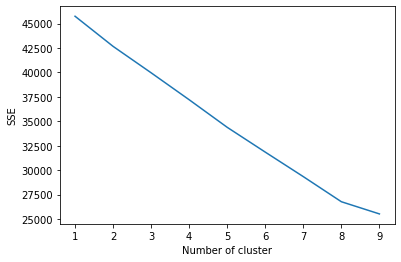

In [198]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=10000, init='k-means++',
                    random_state=0).fit(df_famd)
    #df_famd["cluster"] = kmeans.labels_
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

the elbow method does not really allow to conclude on the optimal number of clusters for FAMD + KMeans, we choose k = 3 as it's suggest by the other two method

In [199]:
kmeans_famd = KMeans(n_clusters=3,max_iter=10000, init='k-means++', random_state=0).fit(df_famd)

In [200]:
clusters = kmeans_famd.labels_

In [201]:
df_famd_clust = df_famd.copy()
df_famd_clust['cluster'] = clusters

<AxesSubplot:xlabel='famd_0', ylabel='famd_1'>

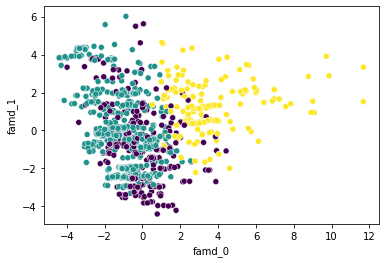

In [202]:
sn.scatterplot(x=df_famd_clust["famd_0"], y=df_famd_clust["famd_1"], c=df_famd_clust['cluster'])

# Compare results

In [203]:
df_clusters = pd.merge(df, df_dummy_clust['cluster'].rename('cluster_dummy'), left_index=True, right_index=True)
df_clusters = pd.merge(df_clusters, df_famd_clust['cluster'].rename('cluster_famd'), left_index=True, right_index=True)
df_clusters = pd.merge(df_clusters, df_pca_mca_clust['cluster'].rename('cluster_pca_mca'), left_index=True, right_index=True)

In [205]:
stats_clust_dummy = df_clusters.groupby(['cluster_dummy'])[numerical].describe(percentiles=[0.5]).transpose()
stats_clust_dummy.columns = ['dummy_{}'.format(_) for _ in range(3)]

stats_clust_famd = df_clusters.groupby(['cluster_famd'])[numerical].describe(percentiles=[0.5]).transpose()
stats_clust_famd.columns = ['famd_{}'.format(_) for _ in range(3)]

stats_clust_pca_mca = df_clusters.groupby(['cluster_pca_mca'])[numerical].describe(percentiles=[0.5]).transpose()
stats_clust_pca_mca.columns = ['pca_mca_{}'.format(_) for _ in range(3)]

stats_numerical = pd.concat([pd.concat([stats_clust_dummy,stats_clust_famd], axis=1),stats_clust_pca_mca], axis=1)

In [206]:
stats_clust_dummy = df_clusters.groupby(['cluster_dummy'])[categorical].agg(func = [('mode', lambda x : x.mode()),('frequency', lambda x : x.value_counts(normalize = True).max())]).transpose()
stats_clust_dummy.columns = ['dummy_{}'.format(_) for _ in range(3)]

stats_clust_famd = df_clusters.groupby(['cluster_famd'])[categorical].agg(func = [('mode', lambda x : x.mode()),('frequency', lambda x : x.value_counts(normalize = True).max())]).transpose()
stats_clust_famd.columns = ['famd_{}'.format(_) for _ in range(3)]

stats_clust_pca_mca = df_clusters.groupby(['cluster_pca_mca'])[categorical].agg(func = [('mode', lambda x : x.mode()),('frequency', lambda x : x.value_counts(normalize = True).max())]).transpose()
stats_clust_pca_mca.columns = ['pca_mca_{}'.format(_) for _ in range(3)]

stats_categorical = pd.concat([pd.concat([stats_clust_dummy,stats_clust_famd], axis=1),stats_clust_pca_mca], axis=1)

In [207]:
stats = pd.concat([stats_numerical, stats_categorical], axis=0)
stats

dummy_0      dummy_1      dummy_2  \
Credit amount    count              56.0        728.0        216.0   
                 mean       11695.589286  1890.082418   5742.24537   
                 std         2274.279536   882.555974  1409.657834   
                 min              8858.0        250.0       3832.0   
                 50%             11191.0       1745.0       5726.5   
                 max             18424.0       3812.0       8648.0   
Age              count              56.0        728.0        216.0   
                 mean          36.053571    35.318681    36.180556   
                 std           11.219171    11.427185    11.263846   
                 min                21.0         19.0         20.0   
                 50%                34.5         33.0         34.0   
                 max                68.0         75.0         75.0   
Duration         count              56.0        728.0        216.0   
                 mean          39.660714    16.718407    30.143519   
                 std           13.268249       8.3364    12.606486   
                 min                 6.0          4.0          6.0   
                 50%                36.0         15.0         27.5   
                 max                60.0         48.0         72.0   
Sex              mode               male         male         male   
                 frequency      0.803571     0.664835      0.74537   
Job              mode                  3            2            2   
                 frequency      0.482143     0.653846     0.611111   
Housing          mode                own          own          own   
                 frequency      0.553571     0.736264     0.675926   
Saving accounts  mode             little       little       little   
                 frequency      0.821429     0.766484     0.842593   
Checking account mode             little       little       little   
                 frequency      0.553571     0.682692     0.648148   
Purpose          mode                car     radio/TV          car   
                 frequency      0.517857     0.326923     0.412037   

                                 famd_0       famd_1       famd_2  \
Credit amount    count            276.0        554.0        170.0   
                 mean       3040.884058  2726.303249  5421.188235   
                 std        2641.019828  2114.875908   3924.89019   
                 min              276.0        250.0        700.0   
                 50%             2202.0       2133.0       4654.5   
                 max            15945.0      15653.0      18424.0   
Age              count            276.0        554.0        170.0   
                 mean         32.663043    34.942238    42.194118   
                 std           9.719645    11.088674    12.232122   
                 min               19.0         19.0         22.0   
                 50%               30.0         32.0         39.5   
                 max               67.0         74.0         75.0   
Duration         count            276.0        554.0        170.0   
                 mean         20.648551    19.258123    26.676471   
                 std          12.416252    10.528879    14.264452   
                 min                6.0          4.0          6.0   
                 50%               18.0         18.0         24.0   
                 max               72.0         60.0         60.0   
Sex              mode              male         male         male   
                 frequency     0.663043     0.662455     0.823529   
Job              mode                 2            2            3   
                 frequency     0.652174     0.705776     0.582353   
Housing          mode               own          own         free   
                 frequency     0.786232     0.787004          0.6   
Saving accounts  mode            little       little       little   
                 frequency     0.568841     0.861011     0.894118   

<AxesSubplot:xlabel='Age', ylabel='Credit amount'>

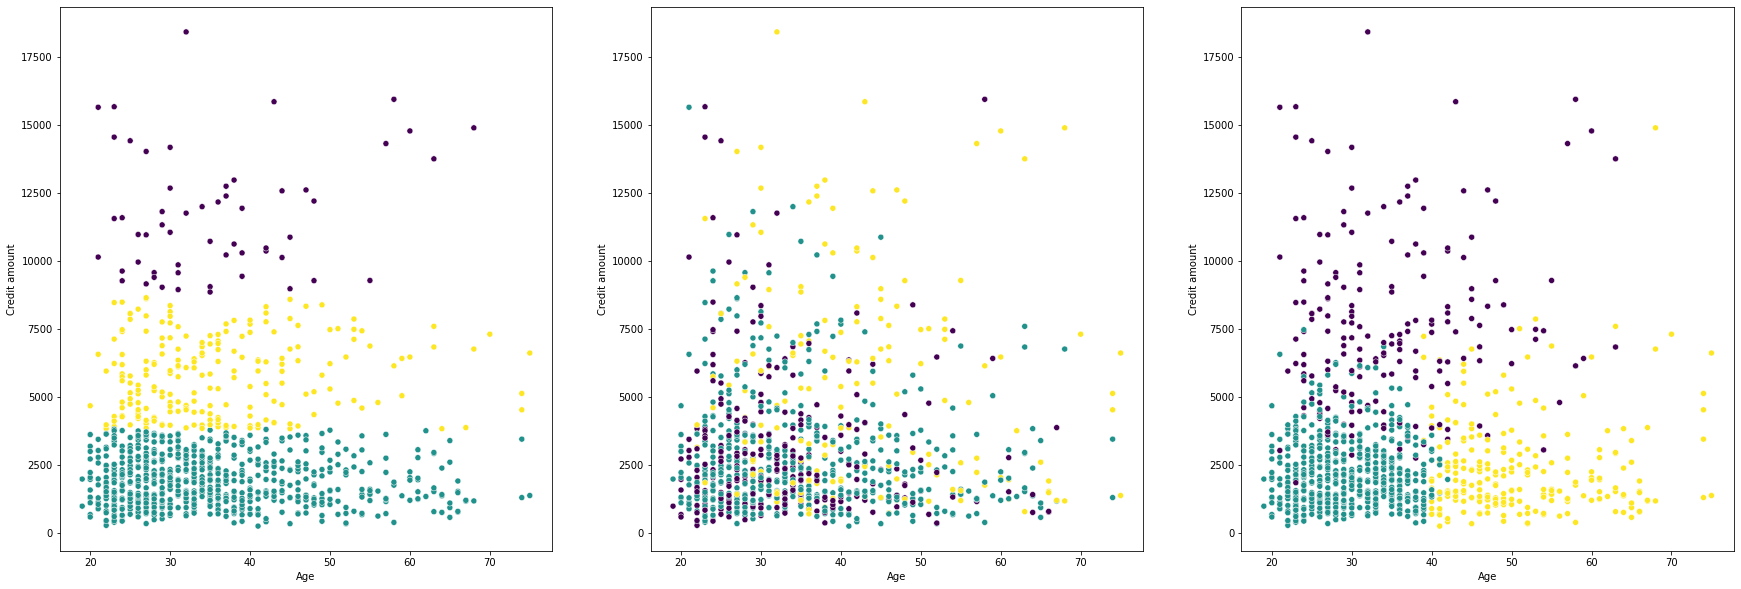

In [208]:
fig, axs = plt.subplots(ncols=3, figsize=(30,10))
sn.scatterplot(x=df_clusters['Age'], y=df_clusters['Credit amount'], c=df_clusters['cluster_dummy'], ax=axs[0])
sn.scatterplot(x=df_clusters['Age'], y=df_clusters['Credit amount'], c=df_clusters['cluster_famd'], ax=axs[1])
sn.scatterplot(x=df_clusters['Age'], y=df_clusters['Credit amount'], c=df_clusters['cluster_pca_mca'], ax=axs[2])

<AxesSubplot:xlabel='Duration', ylabel='Credit amount'>

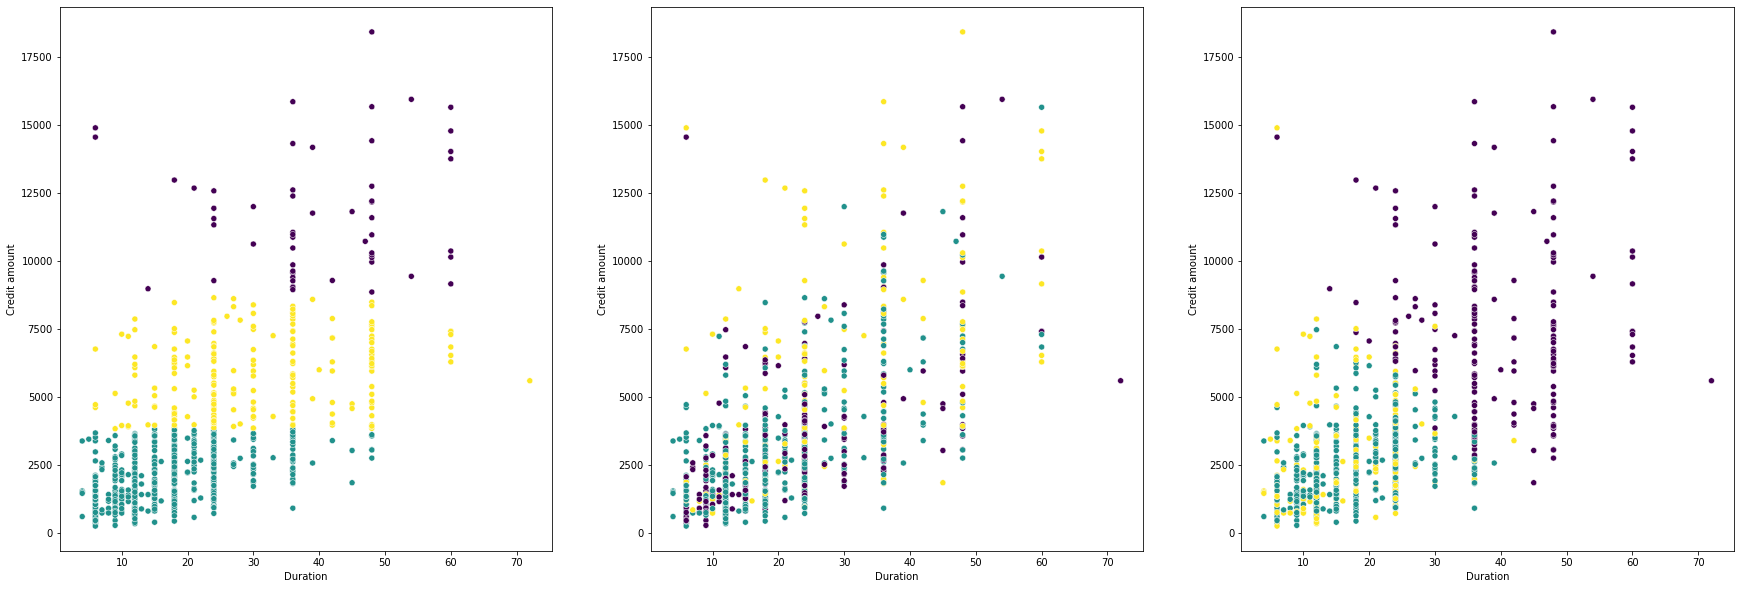

In [209]:
fig, axs = plt.subplots(ncols=3, figsize=(30,10))
sn.scatterplot(x=df_clusters['Duration'], y=df_clusters['Credit amount'], c=df_clusters['cluster_dummy'], ax=axs[0])
sn.scatterplot(x=df_clusters['Duration'], y=df_clusters['Credit amount'], c=df_clusters['cluster_famd'], ax=axs[1])
sn.scatterplot(x=df_clusters['Duration'], y=df_clusters['Credit amount'], c=df_clusters['cluster_pca_mca'], ax=axs[2])

<AxesSubplot:xlabel='Job', ylabel='Credit amount'>

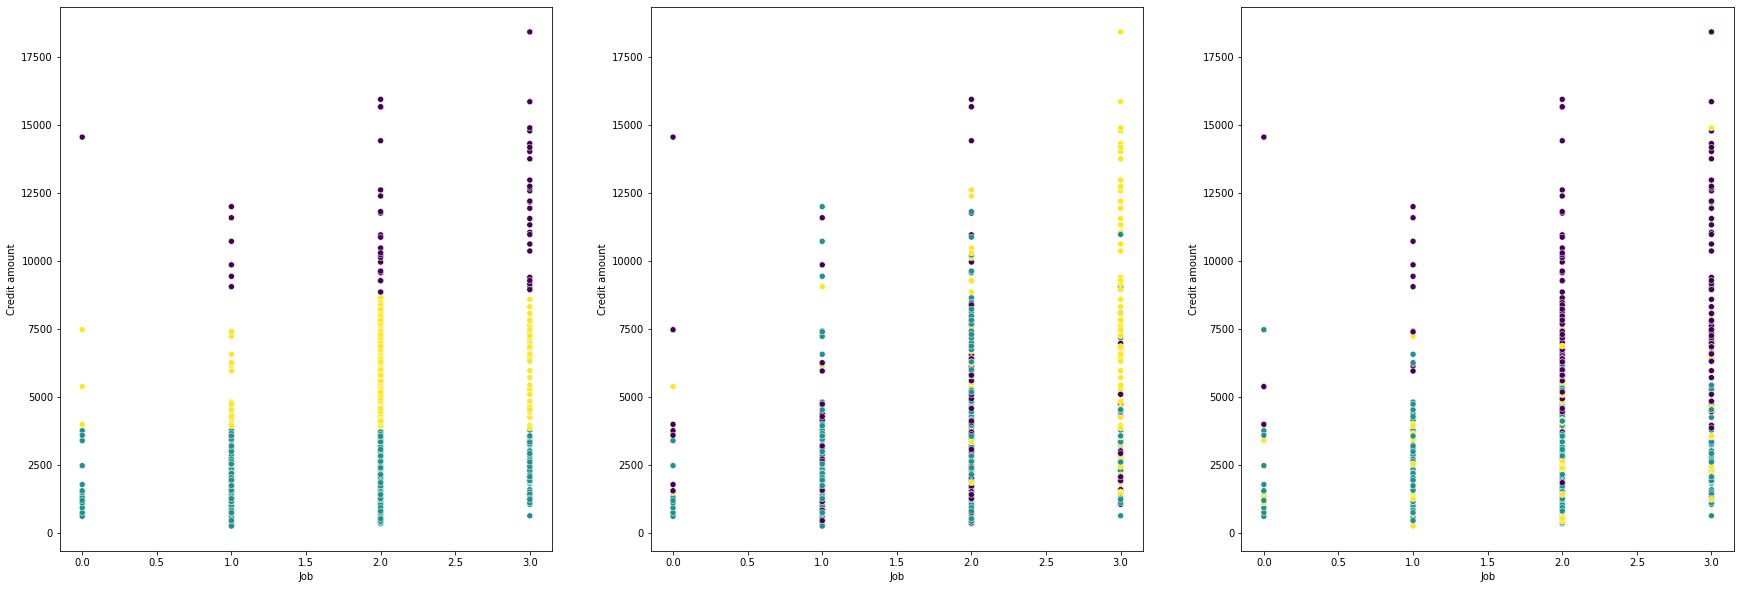

In [210]:
fig, axs = plt.subplots(ncols=3, figsize=(30,10))
sn.scatterplot(x=df_clusters['Job'], y=df_clusters['Credit amount'], c=df_clusters['cluster_dummy'], ax=axs[0])
sn.scatterplot(x=df_clusters['Job'], y=df_clusters['Credit amount'], c=df_clusters['cluster_famd'], ax=axs[1])
sn.scatterplot(x=df_clusters['Job'], y=df_clusters['Credit amount'], c=df_clusters['cluster_pca_mca'], ax=axs[2])

<AxesSubplot:xlabel='Saving accounts', ylabel='Credit amount'>

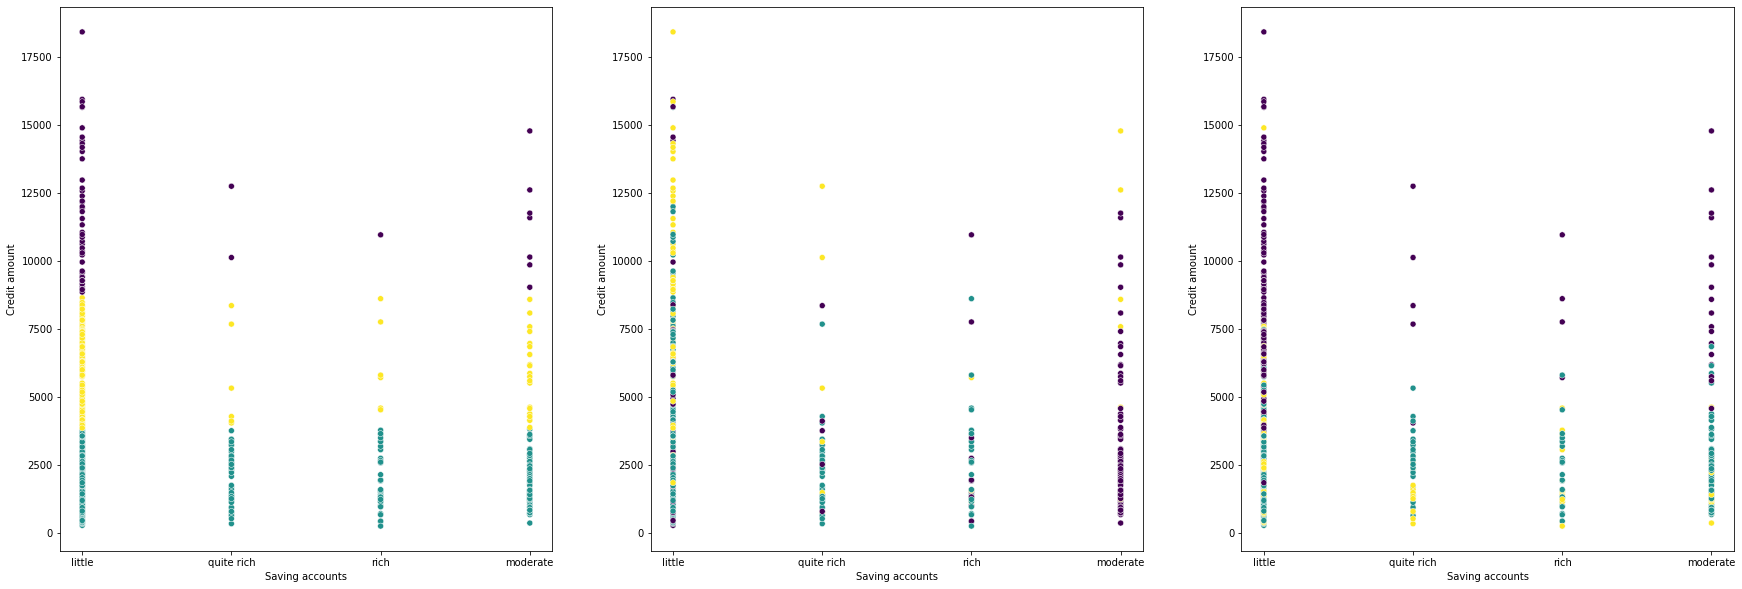

In [211]:
fig, axs = plt.subplots(ncols=3, figsize=(30,10))
sn.scatterplot(x=df_clusters['Saving accounts'], y=df_clusters['Credit amount'], c=df_clusters['cluster_dummy'], ax=axs[0])
sn.scatterplot(x=df_clusters['Saving accounts'], y=df_clusters['Credit amount'], c=df_clusters['cluster_famd'], ax=axs[1])
sn.scatterplot(x=df_clusters['Saving accounts'], y=df_clusters['Credit amount'], c=df_clusters['cluster_pca_mca'], ax=axs[2])

<AxesSubplot:xlabel='Checking account', ylabel='Credit amount'>

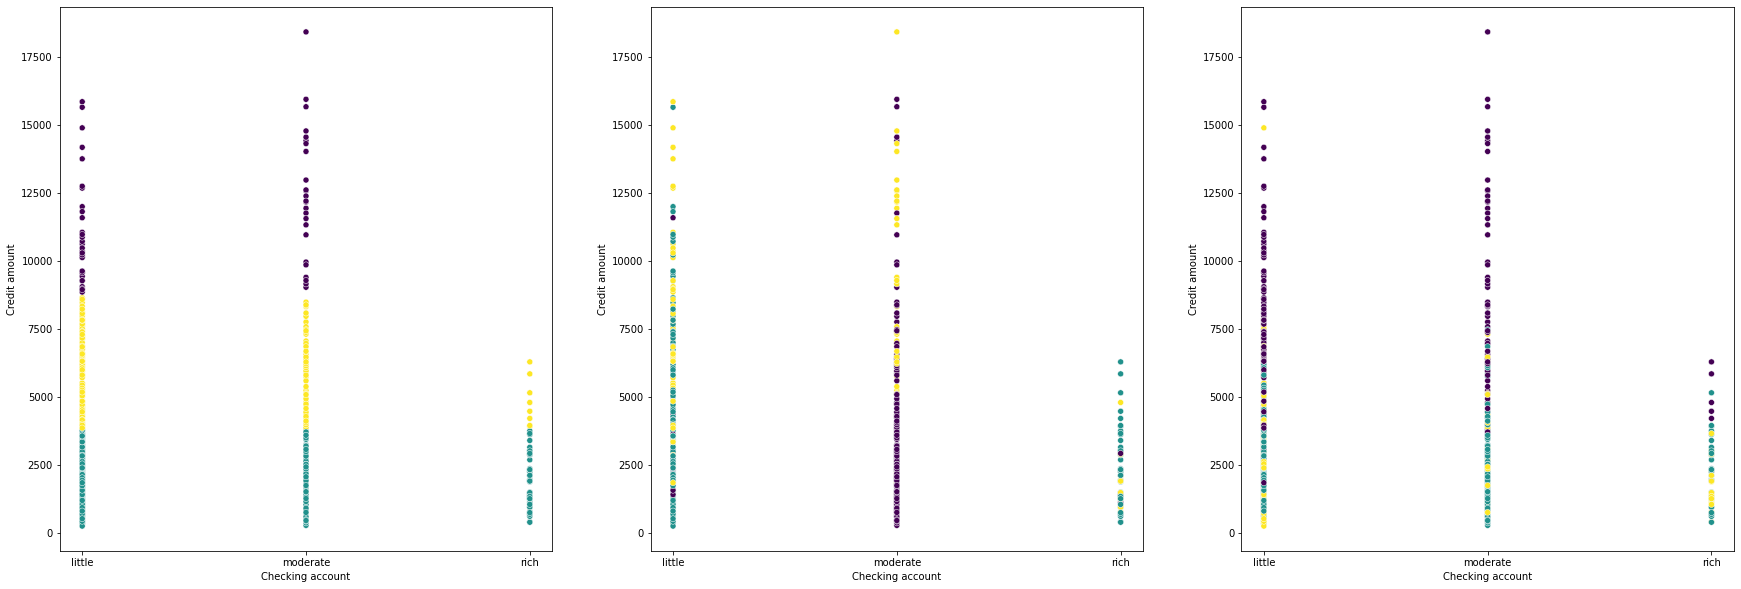

In [212]:
fig, axs = plt.subplots(ncols=3, figsize=(30,10))
sn.scatterplot(x=df_clusters['Checking account'], y=df_clusters['Credit amount'], c=df_clusters['cluster_dummy'], ax=axs[0])
sn.scatterplot(x=df_clusters['Checking account'], y=df_clusters['Credit amount'], c=df_clusters['cluster_famd'], ax=axs[1])
sn.scatterplot(x=df_clusters['Checking account'], y=df_clusters['Credit amount'], c=df_clusters['cluster_pca_mca'], ax=axs[2])


*   The most interpretable model is get dummies but it is also the one with the highest sse
*   Credit amount is the variable that seems to separate observations the most
*   pca/mca model seems  to follow the same trend as get dummies model with a smaller sse but it is more difficult to visually distinguish cluster 1 and 2 with the variables of the dataset 



